<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_augmentation_fourth_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


import csv
from pathlib import Path
from PIL import Image

import librosa as lb 
import librosa.display
import IPython.display as ipd

from skimage.transform import resize
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchvision.io import read_image
from torch.utils.data import DataLoader

from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import exposure

In [3]:
import random

# Augmentation

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
from torchvision.io.image import ImageReadMode
def addNoisy(img):
    noise_img = random_noise(img)
    return noise_img

def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    contrast_img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return contrast_img

# def log_correction(img):
#     log_img = exposure.adjust_log(img)
#     return log_img

def randomGaussian(img):
    gaussian_img = gaussian(img, sigma=random.randint(0, 5))
    return gaussian_img

def doNothing(img):
    return img

def Normalization(img):
    return (MinMaxScaler(img) * 255).astype(np.uint8)


# def addChannels(img):
#     return np.stack((img, img, img))

In [27]:
def augmentation_transformaion(img):
  augmentation_functions = [addNoisy, contrast_stretching,
                    randomGaussian, doNothing, doNothing]
  ind = random.randint(0, len(augmentation_functions) - 1)
  img = augmentation_functions[ind](img)
  return Normalization(img)

In [6]:
class simpleDataset(Dataset):
    def __init__(self, numpy_dataset, numpy_labels, 
                 transform=None, target_transform=None):
        self.dataset = numpy_dataset
        self.labels = numpy_labels
        self.length = len(numpy_labels)
        self.target_transform = target_transform
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.transform != None:
          data = self.transform(self.dataset[idx])
        else:
          data = self.dataset[idx]
        if self.target_transform != None:
          target = self.target_transform(self.labels[idx])
        else:
          target = self.labels[idx]
        return data, target

# Training

## Functions for training

In [20]:
import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import label_ranking_average_precision_score

def crtclass(mdTp,num_classes=24):
  if mdTp == 'Res18':
    modelF = models.resnet18()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res34':
    modelF = models.resnet34()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res50':
    modelF = models.resnet50()
    modelF.fc = nn.Linear(2048, num_classes)
  elif mdTp == 'Alex':
    modelF = models.alexnet()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'VGG':
    modelF = models.vgg16()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'Squeez':
    modelF = models.squeezenet1_0()
    modelF.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
  elif mdTp == 'Modile_v3':
    modelF = models.mobilenet_v3_small()
    modelF.classifier[0] = nn.Linear(in_features=576, out_features=4096, bias=True)
    modelF.classifier[3] = nn.Linear(4096,num_classes,bias=True)
  else:
    assert False, 'no model'
  return modelF

def train_step(model,idata,ilabels,criterion,optimizer,DEVICE):
    model.zero_grad()
    idata = idata.type(torch.FloatTensor).to(DEVICE)
    ilabels = ilabels.type(torch.FloatTensor).to(DEVICE)
    train_output = model(idata)
    #optimizer.zero_grad()
    loss = criterion(train_output, ilabels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test_acc(criterion, test_loader,model,DEVICE):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))

    model.eval()
    acc_array=[]
    labels_output = []
    labels_true = []
    losses = []
    with torch.no_grad():
      for i_test_data, i_test_labels in test_loader:
            i_test_data = i_test_data.type(torch.FloatTensor).to(DEVICE)
            i_test_labels = i_test_labels.type(torch.FloatTensor).to(DEVICE)
            test_output = model(i_test_data)
            losses.append(criterion(test_output, i_test_labels).item())
            i_test_labels = i_test_labels.cpu().detach().numpy()
            test_output = test_output.cpu().detach().numpy()
            

            labels_true+=list(i_test_labels)
            labels_output+=list(test_output)
    labels_true = np.array(labels_true)
    labels_output = sigmoid(np.array(labels_output))
    try:
      score = label_ranking_average_precision_score(labels_true, labels_output)
    except:
      score = 0.0

    return score, np.mean(losses)


## Data Loading

In [8]:
TEST_SIZE = 0.1
BATCH_SIZE = 8

LR = 1e-1
LR_red = 1e-2

MOMENTUM = 0.9

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH_NUM = 100

update_best_models_Flag = True
print(DEVICE)

cuda


In [11]:
PATH_TO_DIR = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_SAVE = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_DIR_TRAIN = '/content/drive/MyDrive/MLDM_proj/prepared_arrays/'

data_tr = np.load(PATH_TO_DIR + 'pure_train.npz')
data_ts = np.load(PATH_TO_SAVE + 'pure_test.npz')
data_mts = np.load(PATH_TO_SAVE + 'MAJOR_test.npz')

In [12]:
train_data = data_tr['data']
train_labels = data_tr['labels']
test_data = data_ts['data']
test_labels = data_ts['labels']
majot_test_data = data_mts['data']

In [13]:
train_dataset = simpleDataset(train_data, train_labels, transform=augmentation_transformaion)
test_dataset = simpleDataset(test_data, test_labels)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Create NN

In [28]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# model_18 = crtclass('Res18').to(DEVICE)
# best_model_18 = crtclass('Res18')
# criterion_18 = nn.BCEWithLogitsLoss()
# optimizer_18 = optim.SGD(model_18.parameters(), lr=LR, momentum=MOMENTUM)

model_18 = crtclass('Res18').to(DEVICE)
best_model_18 = crtclass('Res18')
criterion_18 = nn.CrossEntropyLoss()
optimizer_18 = optim.Adam(model_18.parameters(), lr=LR)
scheduler_18 = ReduceLROnPlateau(optimizer_18, 'min', patience=3,  verbose=True)


# LR = 1e-1

# model_50 = crtclass('Res50').to(DEVICE)
# best_model_50 = crtclass('Res50')
# criterion_50 = nn.BCEWithLogitsLoss()
# optimizer_50 = optim.SGD(model_50.parameters(), lr=LR, momentum=MOMENTUM)



models_arr = [model_18]

criterion_arr = [criterion_18]
optimizer_arr = [optimizer_18]
scheduler_arr = [scheduler_18]

num_models = len(models_arr)

In [29]:
best_models_arr = [best_model_18]
ModelNames = ['Res18']

## Training

In [18]:
generation = 'aumentation_with_functions'
PATH = '/content/drive/MyDrive/MLDM_proj/'

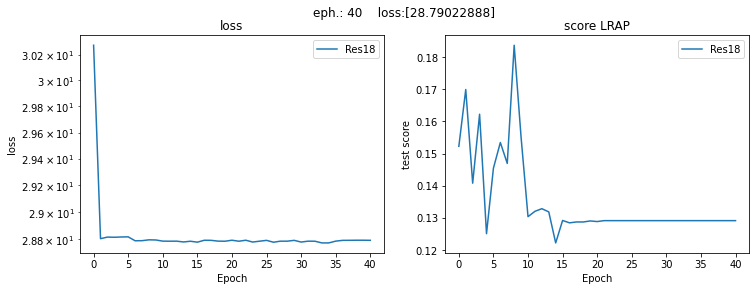

train loader:   0%|          | 0/618 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

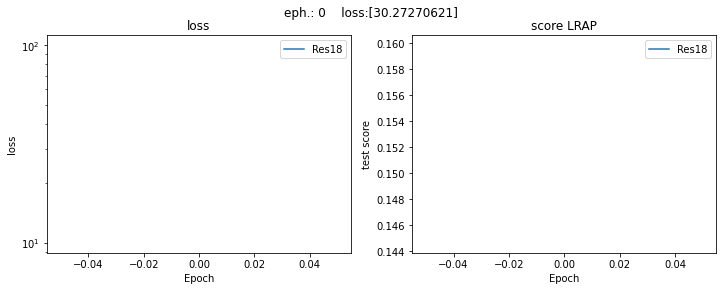

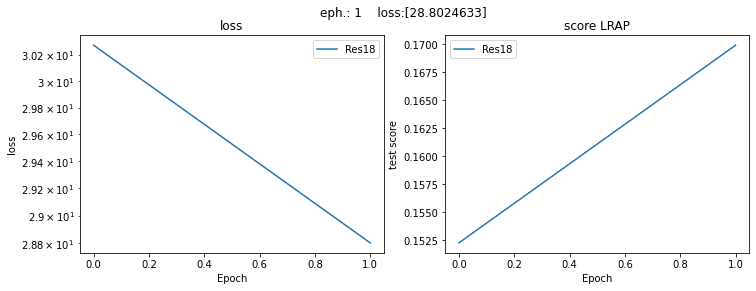

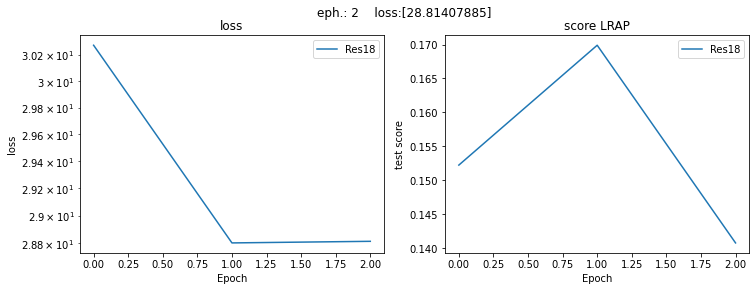

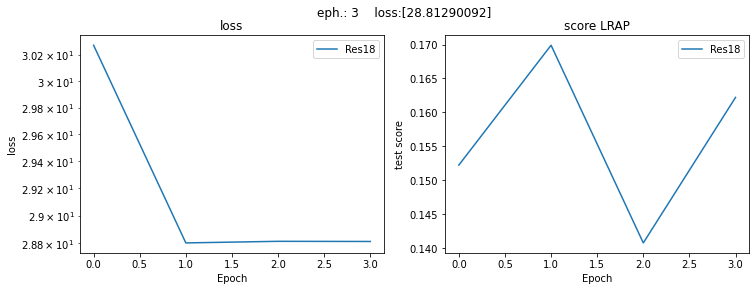

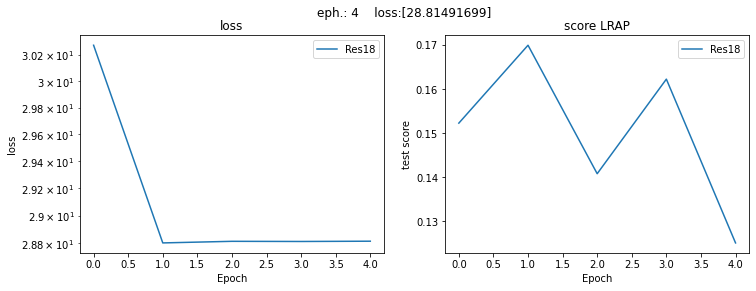

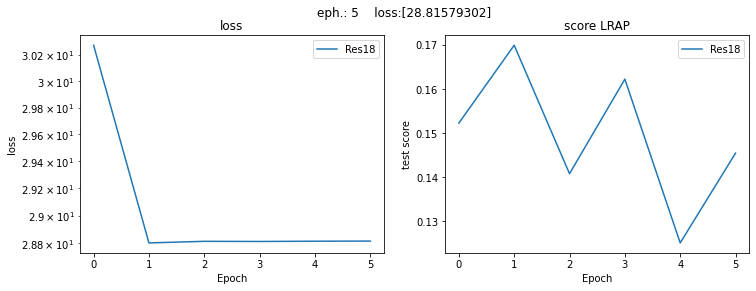

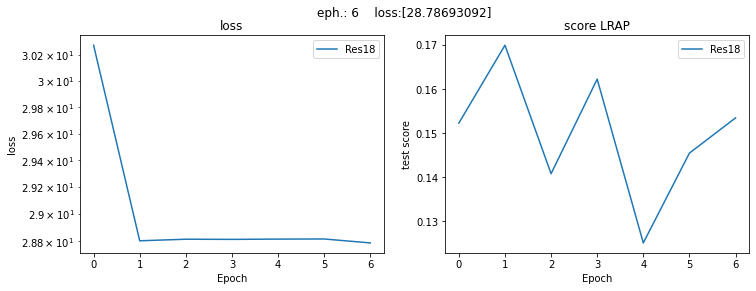

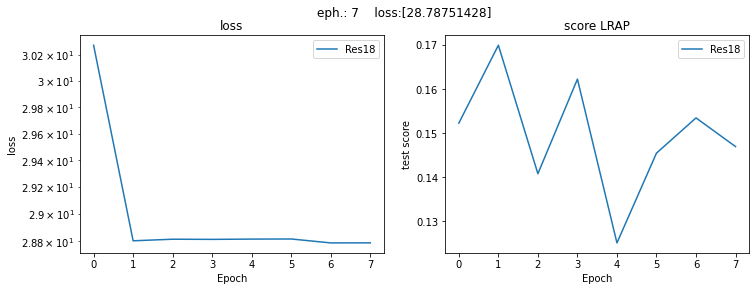

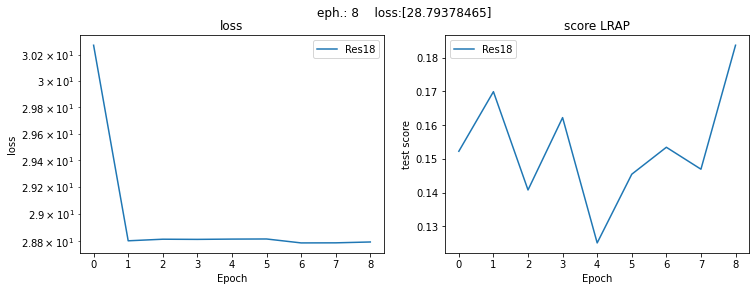

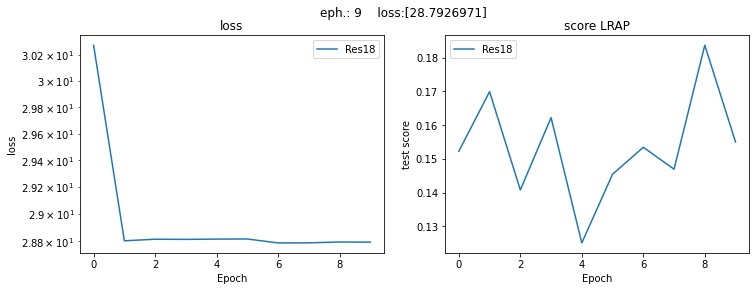

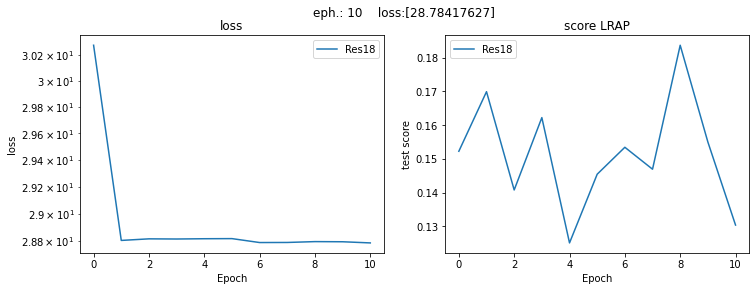

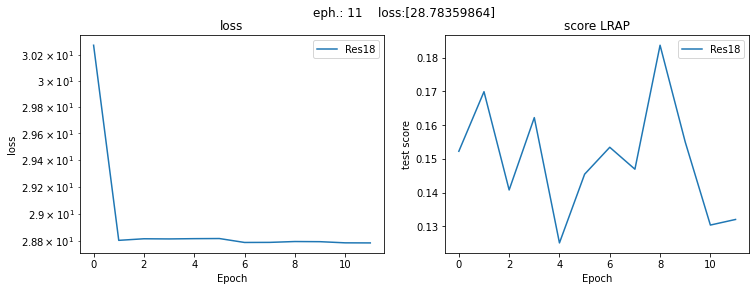

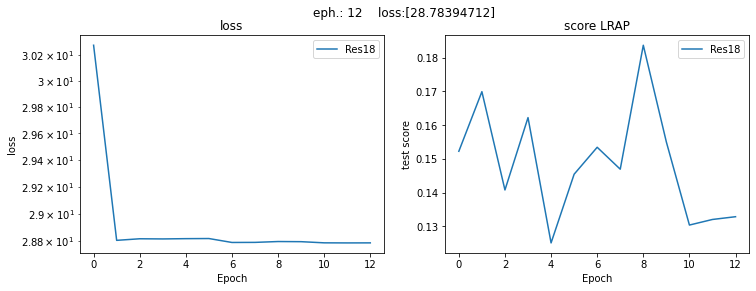

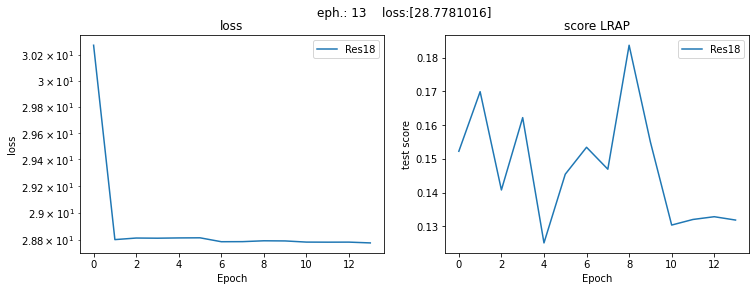

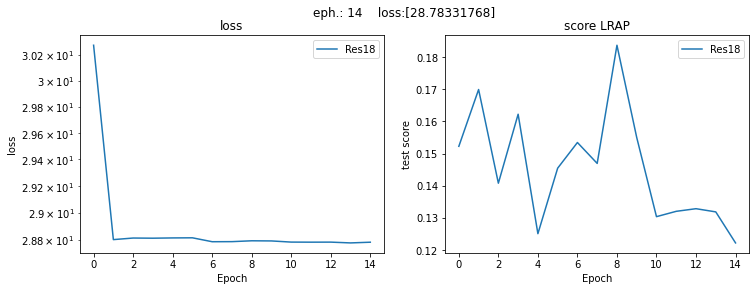

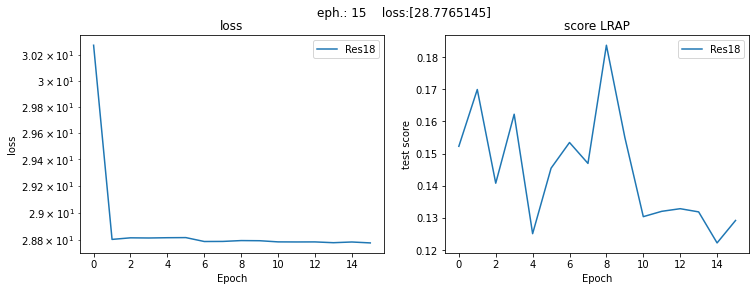

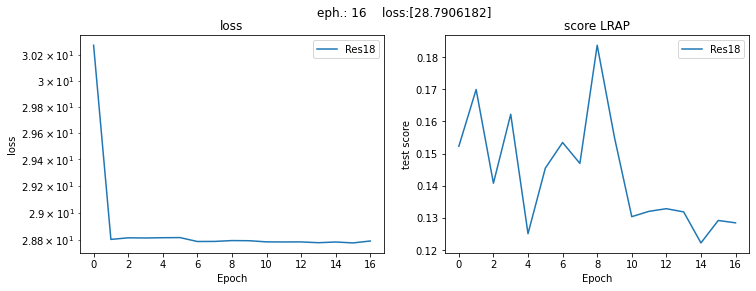

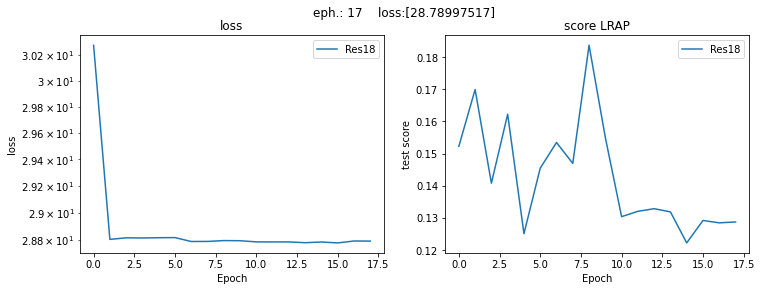

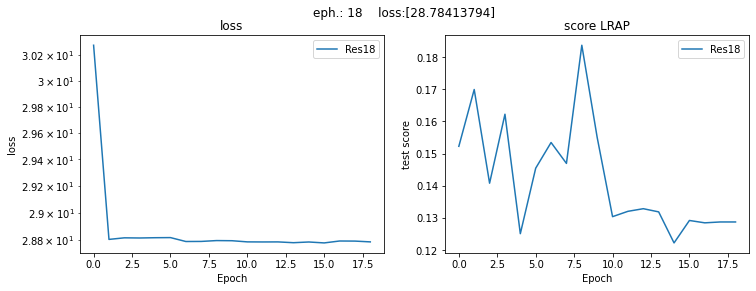

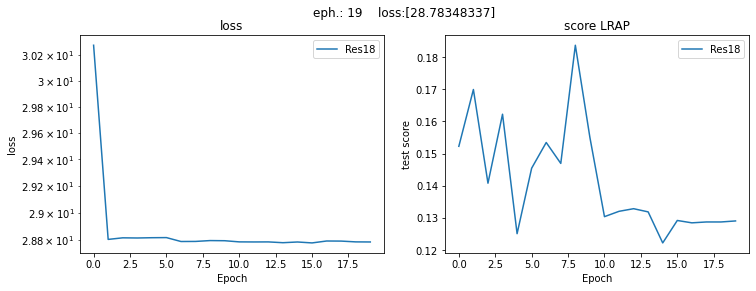

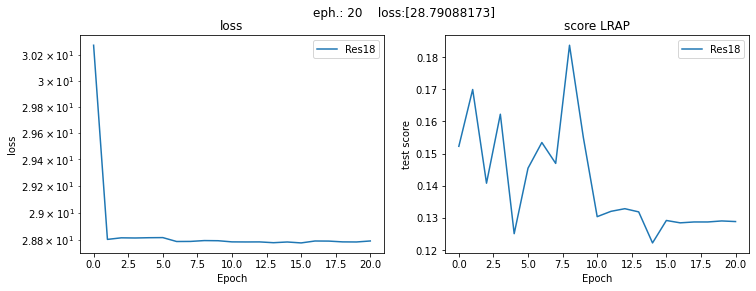

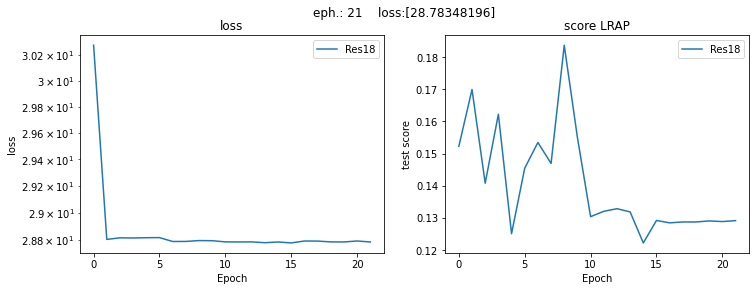

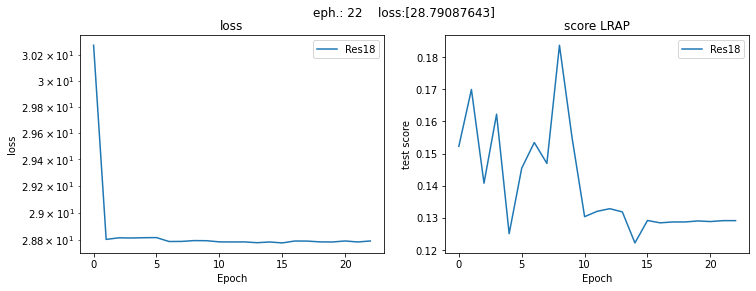

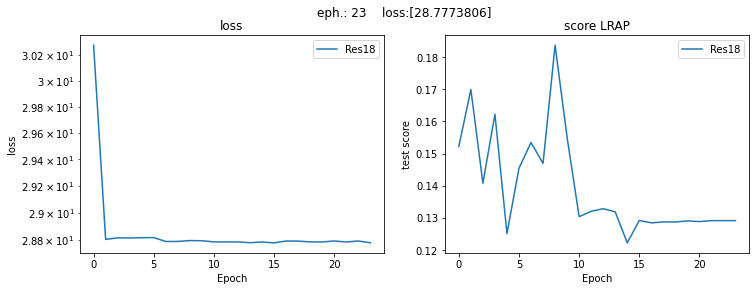

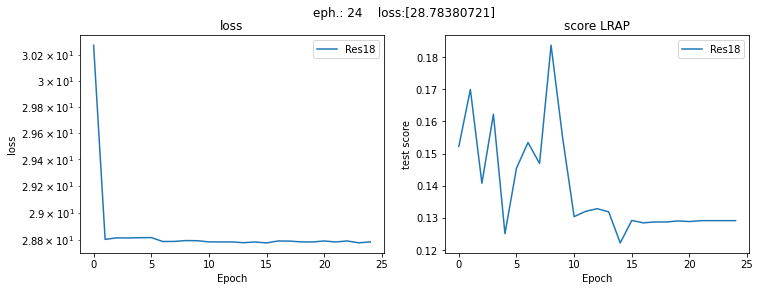

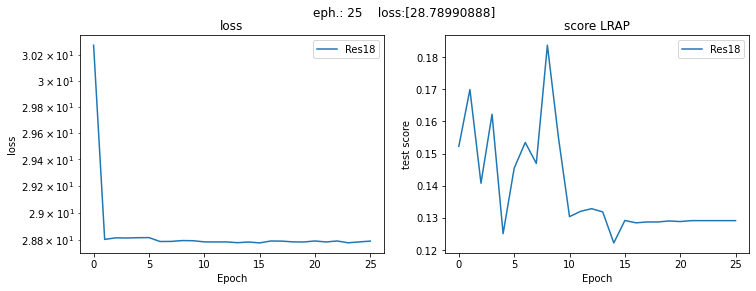

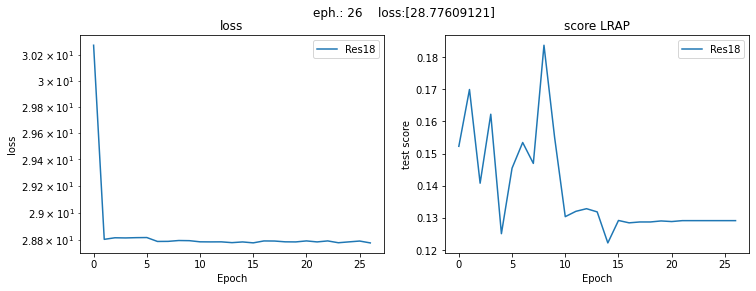

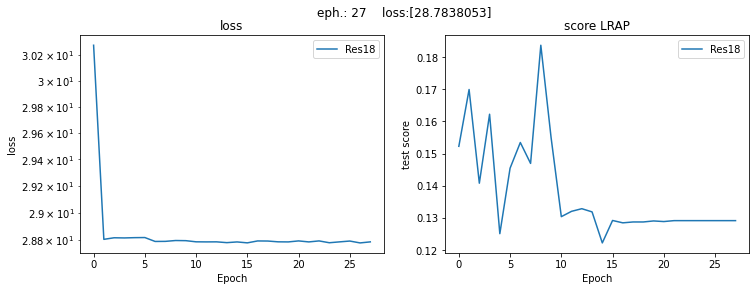

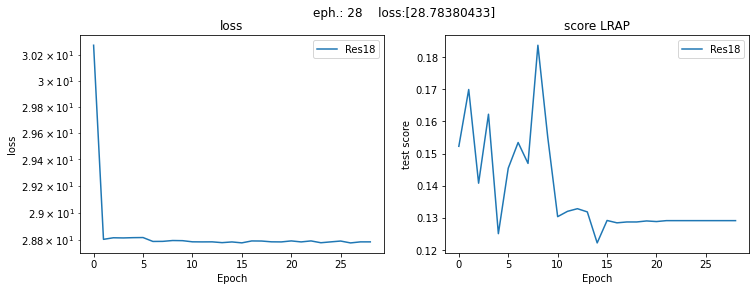

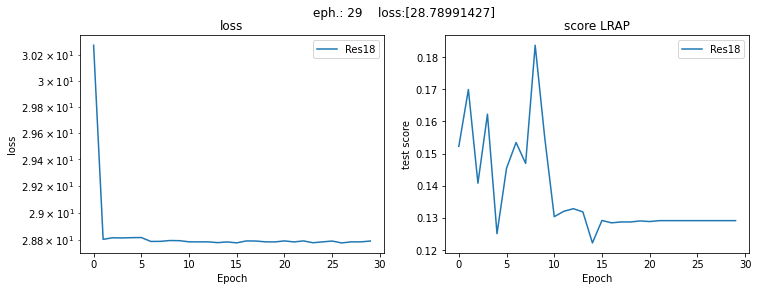

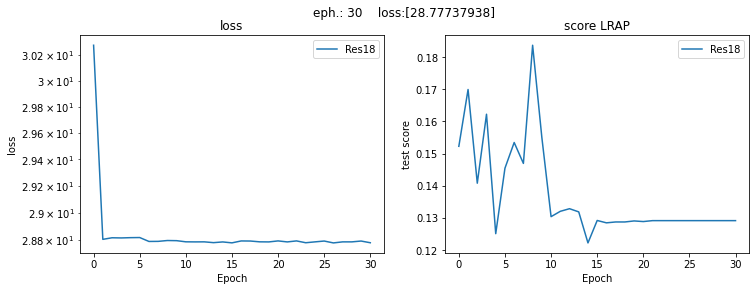

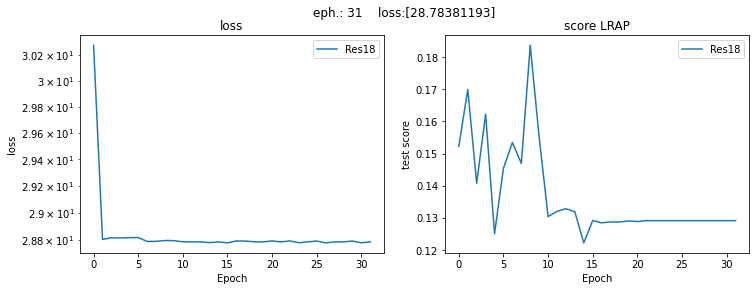

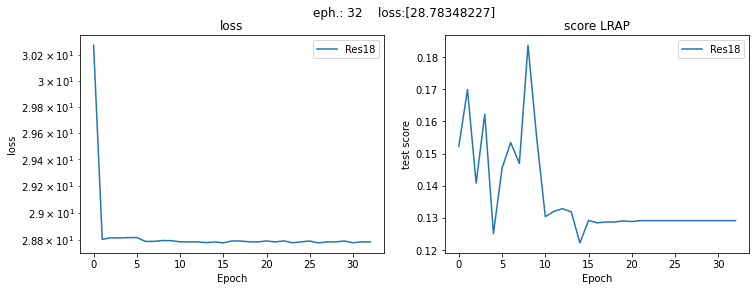

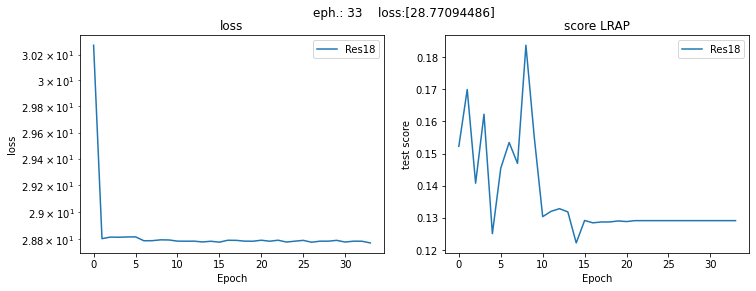

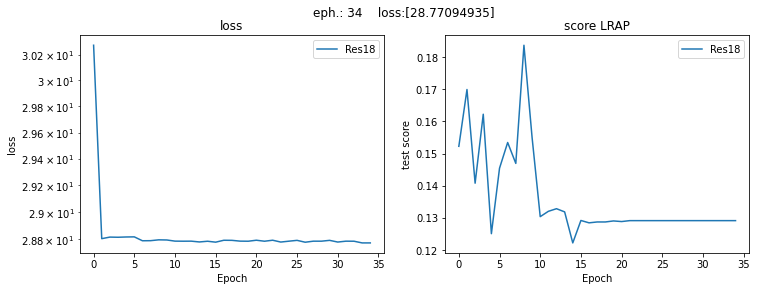

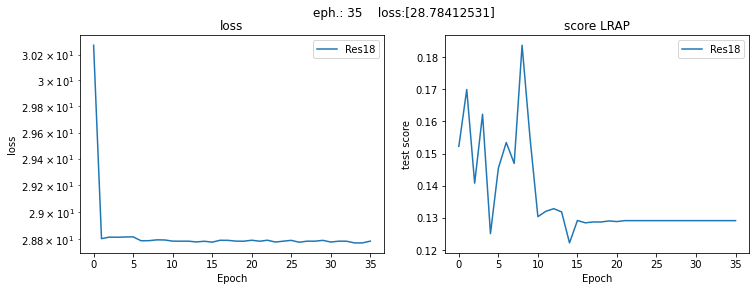

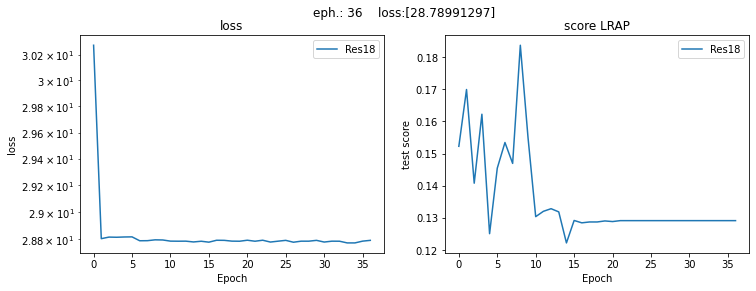

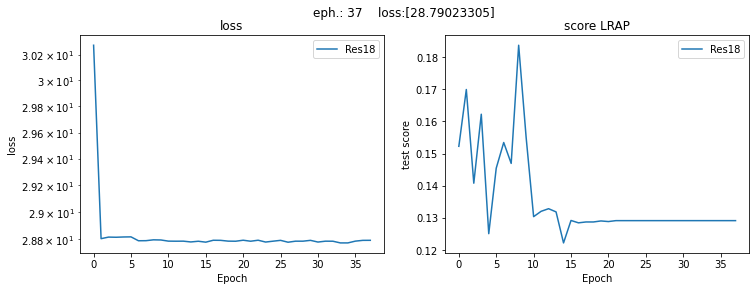

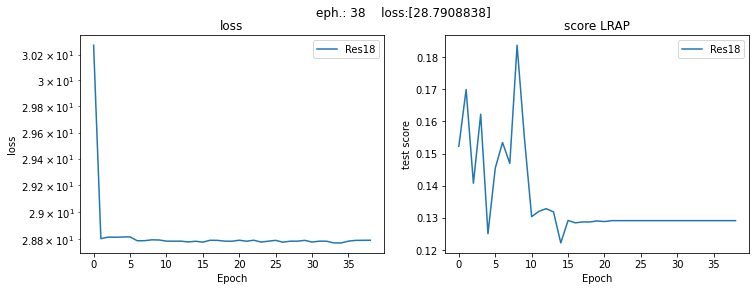

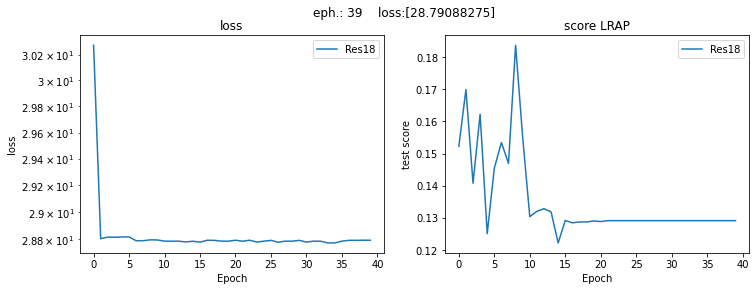

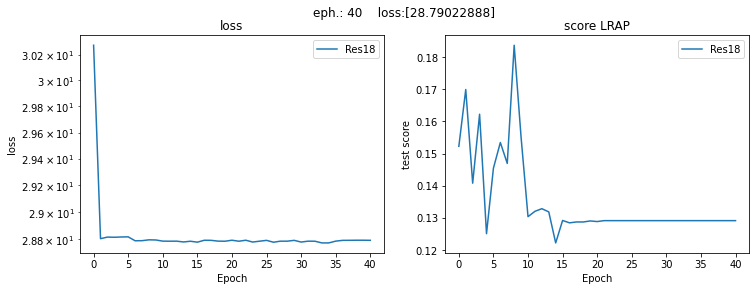

In [30]:
import copy 
from IPython import display
from tqdm.notebook import trange, tqdm

loss_arr = []
test_score_array = [ [] for i in range(num_models)]
max_score = [ 0 for i in range(num_models)]

for iepoch in tqdm(range(EPOCH_NUM),desc='epoch step'):
  inter_loss_arr = []
  for imodel in models_arr:
    imodel.train()
  for idata, ilabels in tqdm(train_loader,desc='train loader'):
    cur_loss_arr = [ [] for i in range(num_models)]
    intI=0
    for imodel,icriterion ,ioptimizer in zip(models_arr,criterion_arr,optimizer_arr):
      cur_loss = train_step(imodel,idata,ilabels,icriterion,ioptimizer,DEVICE)
      cur_loss_arr[intI] = cur_loss
      intI+=1
    inter_loss_arr.append(cur_loss_arr)
  loss_arr.append(np.mean(inter_loss_arr,axis=0))
  cur_test_acc = []
  intI=0

  for imodel,ibest_model, scheduler in zip(models_arr,best_models_arr, scheduler_arr):
    score_cur, test_loss = test_acc(icriterion, test_loader, imodel, DEVICE)
    scheduler.step(test_loss)

    test_score_array[intI].append(score_cur)
    if (score_cur > max_score[intI]) and (update_best_models_Flag):
      max_score[intI]=score_cur
      sd = imodel.state_dict()
      ibest_model.load_state_dict(sd)
      torch.save(sd, PATH+'model_{}_epoch_{:}_{}'.format('Res18', EPOCH_NUM, generation))
    intI+=1

  strOUT_1 = 'eph.: {:} '.format(iepoch)
  strOUT_2 = 'loss:' + str(loss_arr[-1])
  strOUT_4 =  'best score. : '+ str(max_score)
  print(strOUT_1)
  print(strOUT_2)
  print(strOUT_4)
    


  # plot figures in epoch
  loss_arr_np = np.array(loss_arr)
  test_score_array_np = np.array(test_score_array)

  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.suptitle(strOUT_1+'   '+strOUT_2)
  plt.title('loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  for idx,inamne in enumerate(ModelNames):
    plt.plot(loss_arr_np[:,idx],label=inamne)
    plt.yscale('log')
  plt.legend()
  plt.subplot(1,2,2)
  plt.title('score LRAP')
  plt.xlabel('Epoch')
  plt.ylabel('test score')
  for idx,inamne in enumerate(ModelNames):
    plt.plot(test_score_array_np[idx],label=inamne)
  plt.legend()

  display.clear_output(wait=True)
  display.display(plt.gcf())